# Variational Inference



In this notebook, we use a toy example to explore how variational inference works.


Suppose that we are interested in computing the posterior distribution
$$
p(\mu \mid x) = \frac{p(x, \mu)}{p(x)} = \frac{p(x \mid \mu) p(\mu)}{p(x)}
$$
But the posterior $p(\mu \mid x)$ is hard to derive analytically. Furthermore, it is computationally infeasible to apply sampling methods such as MCMC. 

Therefore, we propose an approximation strategy. We approximate the true posterior $p(\mu \mid x)$ with a variational distribution $q(\mu)$ that minimizes the **Kullback–Leibler divergence**:
$$
\text{KL}(q(\mu) \,\|\, p(\mu \mid x)) = \mathbb{E}_{q(\mu)} \left[ \log \frac{q(\mu)}{p(\mu \mid x)} \right]
$$


We can rewrite the KL divergence as
$$
\text{KL}(q(\mu) \,\|\, p(\mu \mid x)) = \log p(x) - \mathbb{E}_{q(\mu)} \left[ \log \frac{p(x, \mu)}{q(\mu)} \right]
$$

Rearranging the terms yield
$$
\log p(x) = \text{KL}(q(\mu) \,\|\, p(\mu \mid x)) + \mathcal{L}(q),
$$
where
$$
\mathcal{L}(q) = \mathbb{E}_{q(\mu)} \left[ \log p(x, \mu) - \log q(\mu) \right].
$$

We call $\mathcal{L}(q)$ the **Evidence Lower Bound (ELBO)**, as it's a lower bound of the log-marginal likelihood $\log p(x)$.

Since $\log p(x)$ is fixed, minizing the KL divergence is equivalent to maximizing the ELBO. In practice, we consider a **family** of variational distribution $q(\mu)$ that is indexed by some parameter $\theta$, and thus our goal is the find the best distribution from this family to maximize ELBO. In other words, we turn the intractable problem of finding the posterior into a tractable optimization problem, at the price of approximation errors. 


### 1. Data Generation
We generate 100 data points from the following mixture of Gaussians
$$
x \sim \frac{1}{2} \mathcal{N}(-2, 0.5^2) + \frac{1}{2} \mathcal{N}(2, 0.5^2)
$$
This will create a bimodal distribution, which we will try to approximate using a Bayesian model that **assumes a single Gaussian**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)

n = 100
component = np.random.binomial(1, 0.5, size=n)
x = np.where(component == 0,
             np.random.normal(-2, 0.5, size=n),
             np.random.normal(2, 0.5, size=n))

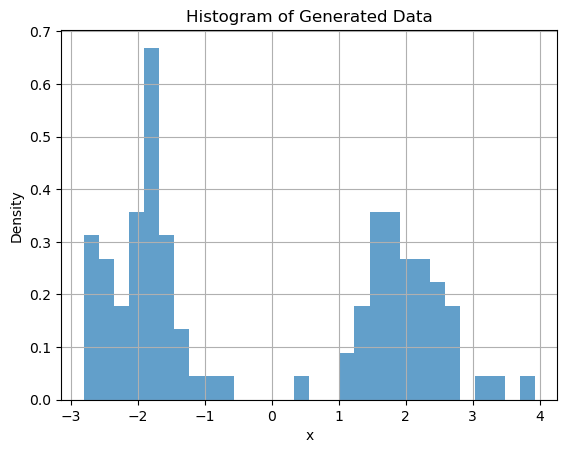

In [2]:
plt.hist(x, bins=30, density=True, alpha=0.7)
plt.title("Histogram of Generated Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.show()

### 2. Variational Inference with a Single Gaussian Family
We now perform variational inference using a simple Gaussian approximation
$$q(\mu) = \mathcal{N}(\mu_q, \sigma_q^2)$$

We use the reparameterization trick and stochastic gradient descent to find the optimal parameters.

In [3]:
import torch
#import torch.nn as nn
import torch.optim as optim

# Prepare data
x_tensor = torch.tensor(x, dtype=torch.float32)

# Variational parameters
mu_q = torch.tensor(0.0, requires_grad=True)
log_sigma_q = torch.tensor(0.0, requires_grad=True)

optimizer = optim.Adam([mu_q, log_sigma_q], lr=0.05)
num_iters = 1000
elbo_vals = []

start_time = time.time()

for _ in range(num_iters):
    # Reparameterization trick
    eps = torch.randn(100)
    mu_sample = mu_q + torch.exp(log_sigma_q) * eps

    log_prior = -0.5 * (mu_sample / 5)**2
    log_likelihood = -0.5 * torch.sum((x_tensor - mu_sample[:, None])**2, dim=1) / 0.5**2
    log_q = -0.5 * ((eps)**2 + 2 * log_sigma_q + np.log(2 * np.pi))

    elbo = torch.mean(log_prior + log_likelihood - log_q)
    loss = -elbo
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    elbo_vals.append(elbo.item())

elapsed_vi1 = time.time() - start_time

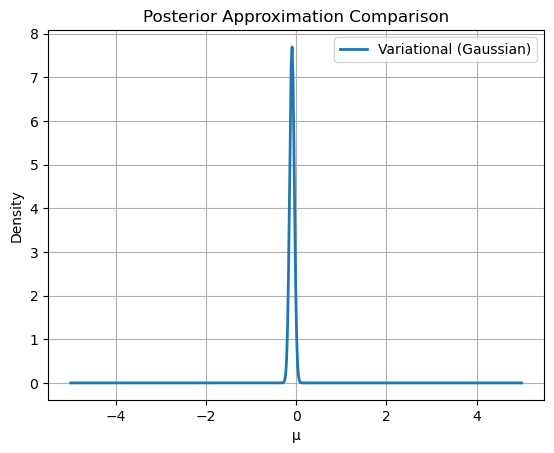

VI mean: -0.092
VI stddev: 0.052
Elapsed time for VI (1 Gaussian): 0.24 seconds


In [5]:

# Plot results
mu_q_val = mu_q.detach().numpy()
sigma_q_val = torch.exp(log_sigma_q).detach().numpy()
from scipy.stats import norm
xx = np.linspace(-5, 5, 500)
vi_density = norm.pdf(xx, mu_q_val, sigma_q_val)

plt.plot(xx, vi_density, label='Variational (Gaussian)', linewidth=2)
plt.title("Posterior Approximation Comparison")
plt.xlabel("μ")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

print(f"VI mean: {mu_q_val:.3f}")
print(f"VI stddev: {sigma_q_val:.3f}")
print(f"Elapsed time for VI (1 Gaussian): {elapsed_vi1:.2f} seconds")